In [1]:
import itertools
import pandas as pd
import utils
from collections import defaultdict, OrderedDict
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.sparse import hstack

/Users/vincent/.virtualenvs/env1/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
ordered_names = [u'study',
                 u'history',
                 u'comparison',
                 u'technique',
                 u'findings',
                 u'impression', 
                 u'signed by',
                 ]

--------

In [3]:
filename = 'Data/upto1528.xlsx'
df_raw = pd.read_excel(open(filename, 'r'))

In [4]:
# get data frame
ps = utils.Parser()
ps.parser(df_raw)
df = ps.df
for idx, row in df['findings'].iteritems():
    try:
        text, velos = utils.parse_findings(row)
        df.set_value(idx, 'findings', text)
        for n, v in velos:
            df.set_value(idx, n, v)
    except:
        pass
discardField = ['Report Text']
foo = [item for item in df.columns.tolist() if item not in ordered_names+discardField]
foo.sort()
CORE_COL = ordered_names + foo
df = df[CORE_COL]
df = pd.concat([df_raw[['Past', 'Present', 'Left', 'Right', 'Count']], df[CORE_COL]], axis=1)

---------

# Classification Model

## Use findings and impression to predict present and pass

In [5]:
# turn null to []
df = utils.null2empty(df, ['history', 'impression', 'comparison'])
print df.shape

(1527, 50)


/Users/vincent/.virtualenvs/env1/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#for PAST
fields = [
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
foo = df[~df['Past'].isnull() & df['Past'] != 0].sample(frac=1, random_state=1)
df_train = foo.iloc[:1220]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[1220:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

(1220, 11495)
(307, 11495)


In [ ]:
#for PAST without inconsistency
fields = [
    'history', 
    'findings', 
    'comparison', 
    'impression',
]
foo = df[~df['Past'].isnull() & df['Count'] != 1].sample(frac=1)
df_train = foo.iloc[:1240]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[1240:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for PRESENT
fields = [
    'history', 
    'findings', 
    'comparison',
    'impression',
]
#'history', 'impression', 'findings', 'comparison'
foo = df[~df['Present'].isnull()].sample(frac=1)
foo = foo.loc[foo['Present']!=0, :]
df_train = foo.iloc[:1100]
y_train = np.array(df_train['Present'].astype(int))
df_test = foo.iloc[1100:]
y_test = np.array(df_test['Present'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=2)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)
# concatenate sparse matrices of all fields
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for Left Grade
fields = ['history', 'findings', 'comparison','impression']
foo = df[~df['Left'].isnull() & df['Left'] != 0].sample(frac=1)
df_train = foo.iloc[:210]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[210:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)

# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

In [ ]:
#for Left Grade
fields = ['history', 'findings', 'comparison','impression']
foo = df[~df['Right'].isnull() & df['Right'] != 0].sample(frac=1)
df_train = foo.iloc[:200]
y_train = np.array(df_train['Past'].astype(int))
df_test = foo.iloc[200:]
y_test = np.array(df_test['Past'].astype(int))
obj = utils.Df2TFIDF()
obj.fit(df_train, fields, ngram=5, min_count=5)
output_train = obj.transform(df_train, fields)
output_test = obj.transform(df_test, fields)

# concatenate sparse matrices of all fields
from scipy.sparse import hstack
x_train = hstack([foo['bow_tfidf'] for foo in output_train.itervalues()])
# TODO (xiao)
x_test = hstack([foo['bow_tfidf'] for foo in output_test.itervalues()])
print x_train.shape
print x_test.shape

### run classifier

In [7]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
# svm
clf = LinearSVC(C=1, loss='squared_hinge')
#clf = SVC()
#clf = LogisticRegression(C=3)

clf.fit(x_train, y_train)
coef = clf.coef_.squeeze()

In [17]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
results = pd.concat([utils.my_classification_report(y_train, y_train_pred),
                     utils.my_classification_report(y_test, y_test_pred),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)

,NPV,accuracy,precision,sensitivity,specificity
training,0.995708,0.996721,1.000000,0.986301,1.000000
testing,0.957983,0.915309,0.768116,0.841270,0.934426


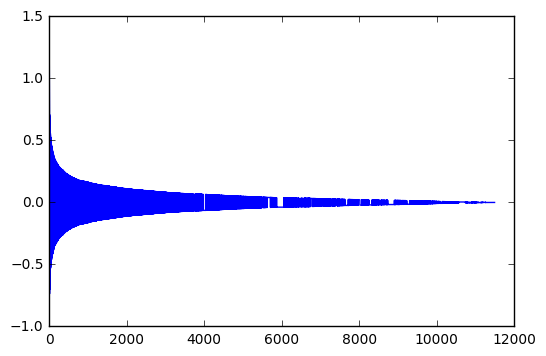

10242                                  a stenosis at the
10248               distal right internal carotid artery
10389                                    plaque analysis
10824             of radiologist in ultrasound consensus
10944                                      c buchanan md
2962                                of the left internal
11135                        compared to the prior study
10867                              reported by krystal c
11103                 significant stenosis identified in
10203                                          of plaque
15                                            distal ica
10947                                  is similar to the
10837                        criteria no hemodynamically
10400                                             burden
10235                                           possible
10993                            carotid artery findings
10383                                 plaque analysis of
10199                     by th

In [9]:
# features with the big weights
idx = np.absolute(coef).argsort()[::-1]
plt.plot(coef[idx])
plt.show()
idx2word_agg = pd.Series(obj.idx2word_concat)
display(idx2word_agg[idx[:20]])

In [18]:
# output failed cases.
pd.set_option('display.max_colwidth', -1)
fields = [
    'Past',
    'history', 
    'findings', 
    'comparison', 
    'impression'
]
false_positive = (y_test_pred - y_test) > 0
display(df_test.loc[false_positive,fields].applymap(utils.list2str))

,Past,history,findings,comparison,impression
1286,-1,"stenosis of carotid artery, unspecified laterality.",there is scattered atherosclerotic disease in the bifurcation regions bilaterally. both carotid systems demonstrate normal waveforms with brisk systolic upstrokes. the velocities on the right are as follows: the velocities on the left are as follows: antegrade flow identified in the right vertebral artery. left vertebral artery was not able to be identified except at its origin.,,scattered atherosclerotic plaque without evidence of hemodynamically significant stenosis. nonvisualization of left vertebral artery which may be secondary to occlusion or hypoplasia.. analysis of internal carotid stenosis is based on duplex doppler velocity parameters that correlate with the calculation of an internal carotid artery stenosis according to the nascet criteria.
1191,-1,dizziness,calcified plaque is noted that the right carotid bifurcation. associated elevated peak systolic velocities are seen at this level compatible with significant stenosis. normal peak systolic velocities and waveforms are seen in the left carotid system. right carotid velocities: ---------------------------------------------------------------- left carotid velocities: ---------------------------------------------------------------- vertebral arteries: both vertebral arteries demonstrate antegrade flow.,5/13/2013,"slight increase in the peak systolic velocities in the right proximal ica when compared to prior examination, findings are compatible with 50-69% stenosis. analysis of internal carotid stenosis is based on duplex doppler velocity parameters that correlate with the calculation of an internal carotid artery stenosis according to the nascet criteria."
444,-1,dizziness. known stenoses in intracranial vessels.,"there is minimal plaque/intimal thickening the bifurcation regions, most prominent in the left bulb. both carotid systems demonstrate normal waveforms with brisk systolic upstrokes. the velocities on the right are as follows: the velocities on the left are as follows: both vertebral arteries demonstrate antegrade flow.","cta, 3/18/2016.",no evidence of hemodynamically significant stenosis. no interval change noted since prior cta performed 6 days earlier. analysis of internal carotid stenosis is based on duplex doppler velocity parameters that correlate with the calculation of an internal carotid artery stenosis according to the nascet criteria.
1056,-1,"dysarthria, ocular migraines; history of carotid stenosis","there is evidence of mild atherosclerotic disease with mild tortuosity of the carotid arteries. both carotid systems demonstrate brisk systolic upstrokes. noncalcified plaque is seen within the right distal common carotid artery, bilateral carotid bulbs, and throughout the left internal carotid artery. right carotid velocities: ---------------------------------------------------------------- left carotid velocities: ---------------------------------------------------------------- vertebral arteries: both vertebral arteries demonstrate antegrade flow.",carotid duplex ultrasound dated 3/15/2012,no hemodynamically significant stenosis in either carotid artery. areas of noncalcified plaque bilaterally as described. analysis of internal carotid stenosis is based on duplex doppler velocity parameters that correlate with the calculation of an internal carotid artery stenosis according to the nascet criteria.
1258,-1,stroke/tia. cc ratio: 1.5 left: cca: 72.1 proximal ica: 370.1 middle ica: 213.2 distal ica: 112.4 cc ratio: 5.1 both vertebral arteries demonstrate antegrade flow. ... the percentage of carotid stenosis has been calculated utilizing doppler parameters established by the sonographic nascet (north american symptomatic carotid endarterectomy trial) index. ...,"there is intimal thickening with calcified plaque formation at the origin of the internal carotid arteries, left greater than right. the following peak systolic velocity measurements